# Mask R-CNN - Inspect Lung Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.lung import lung

%matplotlib inline 

E:\Anaconda3\envs\tensorflow1.5\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\envs\tensorflow1.5\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\envs\tensorflow1.5\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\envs\tensorflow1.5\lib\site-packages\tensorflow\python\framework\dtypes.

## Configurations

Configurations are defined in virus.py

In [2]:
config = lung.LungConfig()
LUNG_DIR = os.path.join(ROOT_DIR, "datasets/lung") # lung dataset path

## Dataset

In [3]:
# Load dataset

dataset = lung.LungDataset()
dataset.load_lung(LUNG_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 520
Class Count: 2
  0. BG                                                
  1. lung                                              


## Display Samples

Load and display images and masks.

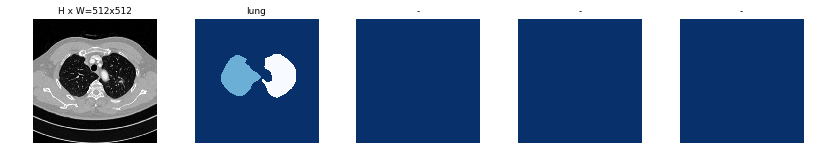

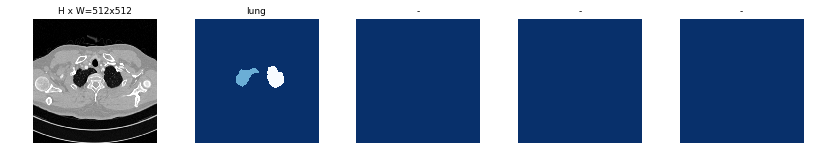

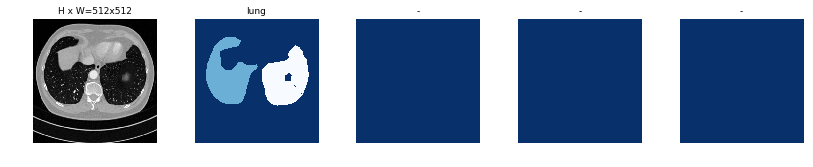

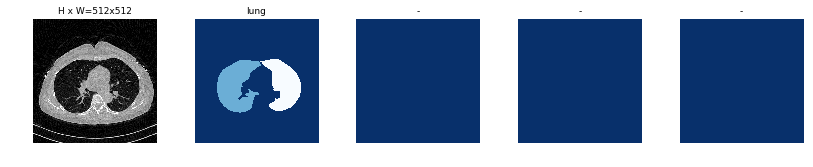

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4) # select 4 samples randomly
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # because lung data has 16 bits, convert to 8bits first
    image_visualize = np.int8(image/(2**8))
    visualize.display_top_masks(image_visualize, mask, class_ids, dataset.class_names)

## Bounding Boxes

compute the bounding boxes from masks instead

image_id  462 D:\学习\大四\毕业设计\My_Mask\code\Lung\datasets/lung\train\images\BA3RGWI0_0134_i.tif
image                    shape: (512, 512, 3)         min:    0.00000  max: 65535.00000  uint16
mask                     shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:   98.00000  max:  429.00000  int32


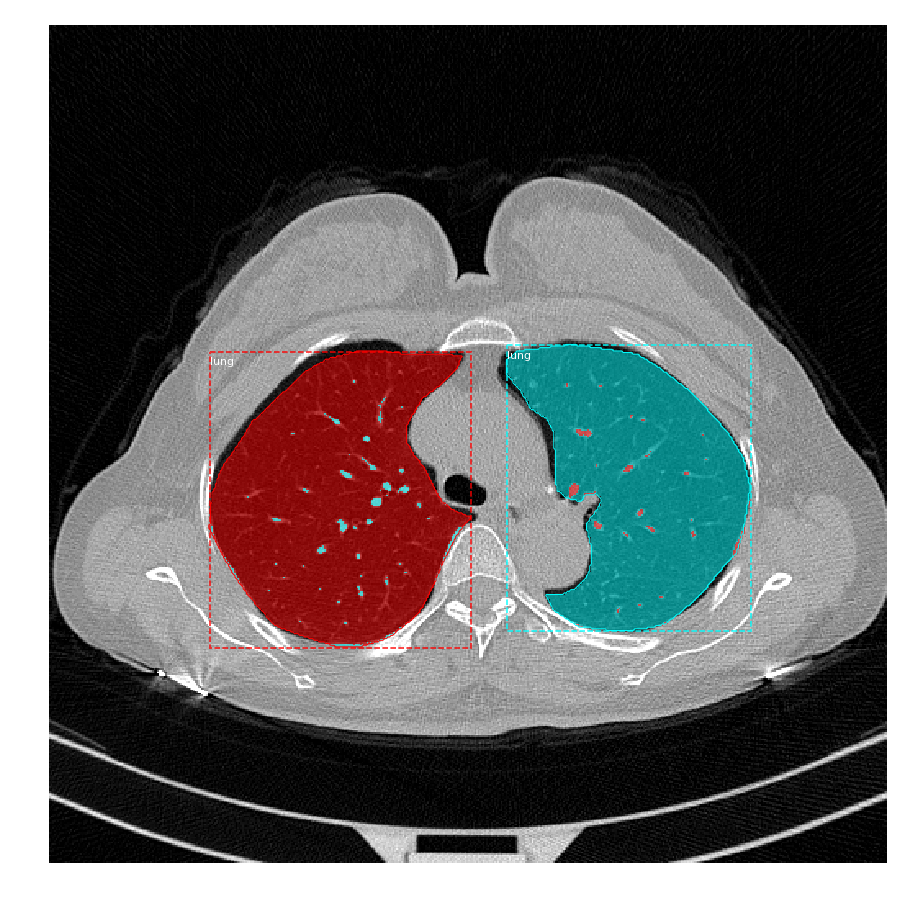

In [5]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
# because lung data has 16 bits, convert to 8bits first
image_visualize = np.int8(image/(2**8))
visualize.display_instances(image_visualize, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  324 D:\学习\大四\毕业设计\My_Mask\code\Lung\datasets/lung\train\images\10548316_0362_i.tif
Original shape:  (512, 512, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max: 65535.00000  uint16
mask                     shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (2, 4)                min:  410.00000  max:  662.00000  int32


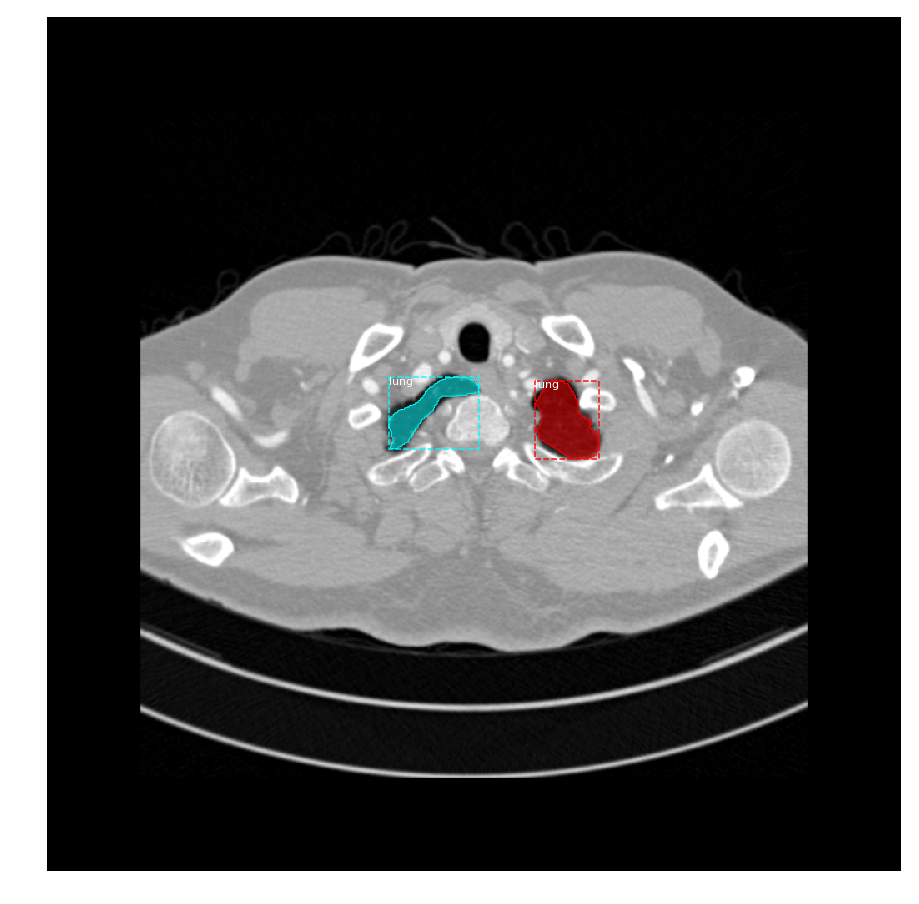

In [6]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
# because lung data has 16 bits, convert to 8bits first
image = np.int8(image/(2**8))
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


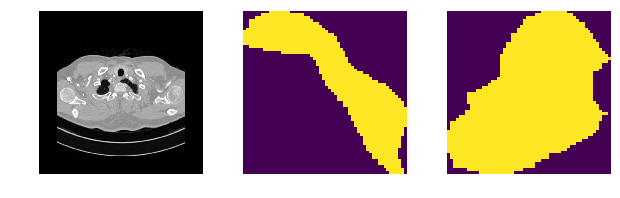

In [7]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)

# because lung data has 16 bits, convert to 8bits first
image_visualize = np.int8(image/(2**8))
display_images([image_visualize]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

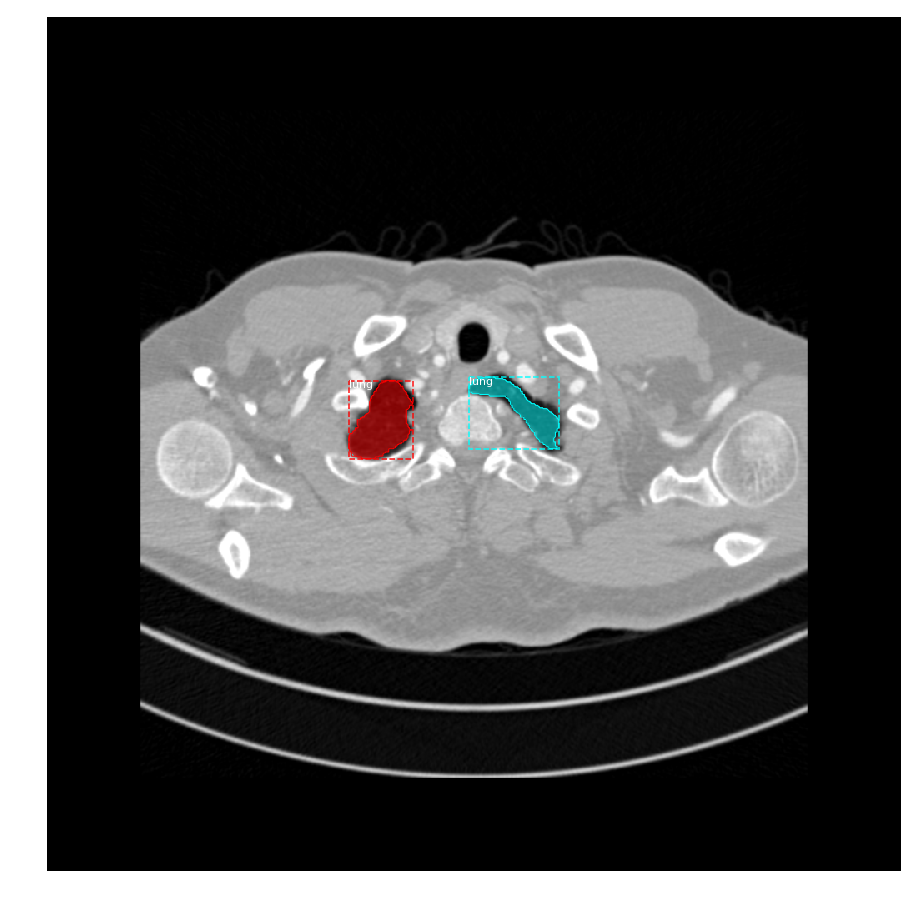

In [8]:
mask = utils.expand_mask(bbox, mask, image.shape)

visualize.display_instances(image_visualize, bbox, mask, class_ids, dataset.class_names)